# Sentiment Classification of Movie Reviews (Hugging Face)

### Notebook Overview

An alternative approach to sentiment classification using the IMDB dataset loaded via Hugging Face. This notebook explores a different workflow to the TF-IDF approach in [01-sentiment-classification](01-sentiment-classification.ipynb), including POS-aware lemmatization, custom stopword removal based on word frequency analysis, and exploratory visualisations.

### 1 - Importing Libraries

In [4]:
# Core Libraries
import re
import numpy as np
import pandas as pd
from collections import Counter

# Data
from datasets import load_dataset

# Visualisations
import matplotlib.pyplot as plt

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Model building
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /Users/annie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/annie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/annie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/annie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/annie/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/annie/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


### 2 - Load & Explore Dataset

The IMDB dataset contains 50,000 movie reviews (25,000 train, 25,000 test). A sample of 500 reviews is used for faster iteration.

In [5]:
# Load IMDB dataset from Hugging Face
dataset = load_dataset('imdb')

# Sample 500 reviews for faster processing
sample_size = 500
train_sample = dataset['train'].shuffle(seed=42).select(range(sample_size))

# Convert to DataFrame and rename columns
df = pd.DataFrame(train_sample)
df.columns = ['review', 'sentiment']
df.head()

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 908266.93 examples/s]


,review,sentiment
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0


In [6]:
# Check for missing values and class balance
print(df.isnull().sum())
print()
print(df['sentiment'].value_counts(normalize=True))

review       0
sentiment    0
dtype: int64

sentiment
0    0.508
1    0.492
Name: proportion, dtype: float64


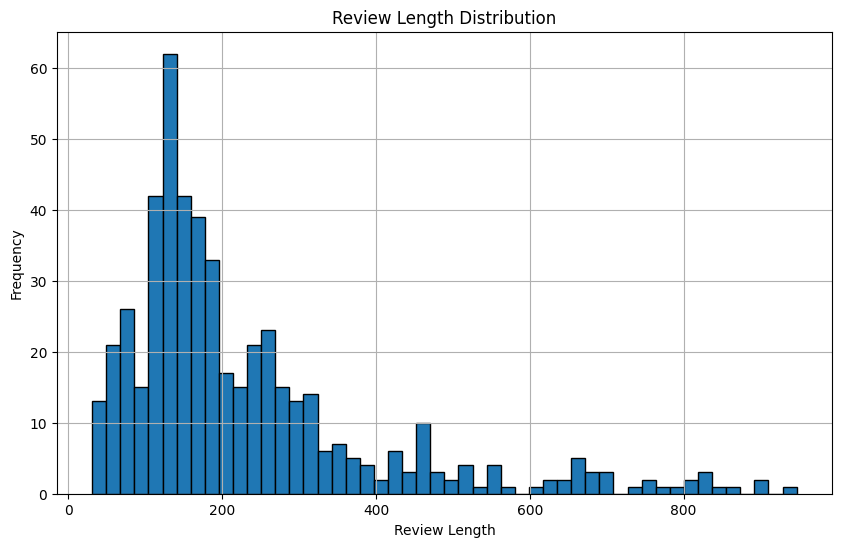

In [7]:
# Review length distribution
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
df['review_length'].hist(bins=50, edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.show()

### 3 - Text Preprocessing

Text is cleaned by lowercasing, removing numbers and punctuation, then tokenised with POS-aware lemmatization and stopword removal.

In [ ]:
def clean_text(text):
    # Lowercase, remove numbers and punctuation
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)
df.head()

In [ ]:
def get_wordnet_pos(tag):
    # Map POS tag to WordNet POS for better lemmatization
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(review):
    # Tokenize, POS-tag, lemmatize, and remove stopwords
    words = word_tokenize(review)
    tagged_tokens = pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return words

# Apply tokenization
df['clean_review'] = df['clean_review'].apply(ttokenize_and_remove_stopwords)
df.head()

,review,sentiment,review_length,clean_review
0,There is no relation at all between Fortier an...,1,125,"[relation, fortier, profiler, fact, police, se..."
1,This movie is a great. The plot is very true t...,1,131,"[movie, great, plot, true, book, classic, writ..."
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,177,"[george, cosmatos, rambo, first, blood, part, ..."
3,In the process of trying to establish the audi...,1,119,"[process, try, establish, audience, empathy, j..."
4,"Yeh, I know -- you're quivering with excitemen...",0,636,"[yeh, know, youre, quiver, excitement, well, s..."


### 4 - Word Frequency Analysis

Visualise the most common words in positive and negative reviews to identify shared high-frequency words that can be removed as custom stopwords.

In [10]:
# Split by sentiment and count word frequencies
positive_reviews = df[df['sentiment'] == 1]
negative_reviews = df[df['sentiment'] == 0]

positive_tokens = [word for review in positive_reviews['clean_review'] for word in review]
negative_tokens = [word for review in negative_reviews['clean_review'] for word in review]

positive_top_words = Counter(positive_tokens).most_common(15)
negative_top_words = Counter(negative_tokens).most_common(15)

positive_df = pd.DataFrame(positive_top_words, columns=['Word', 'Count'])
negative_df = pd.DataFrame(negative_top_words, columns=['Word', 'Count'])

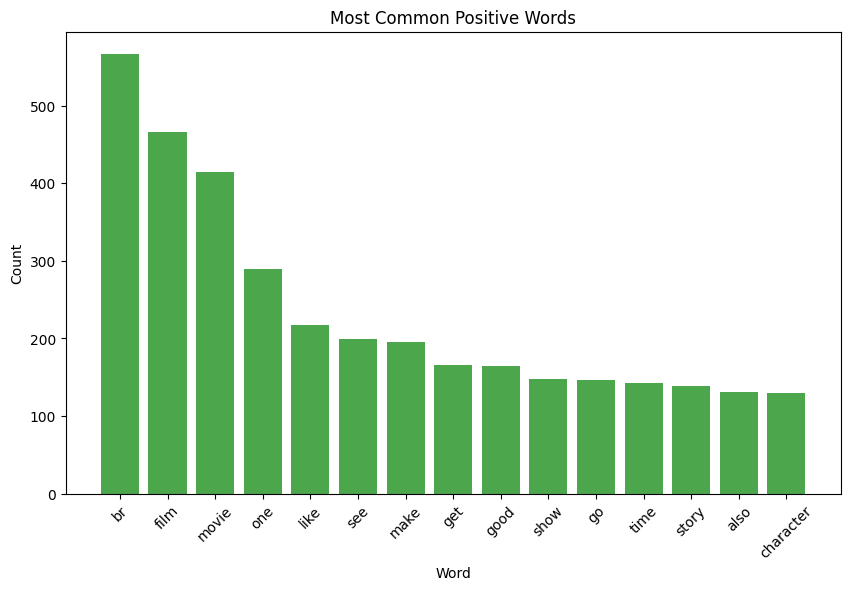

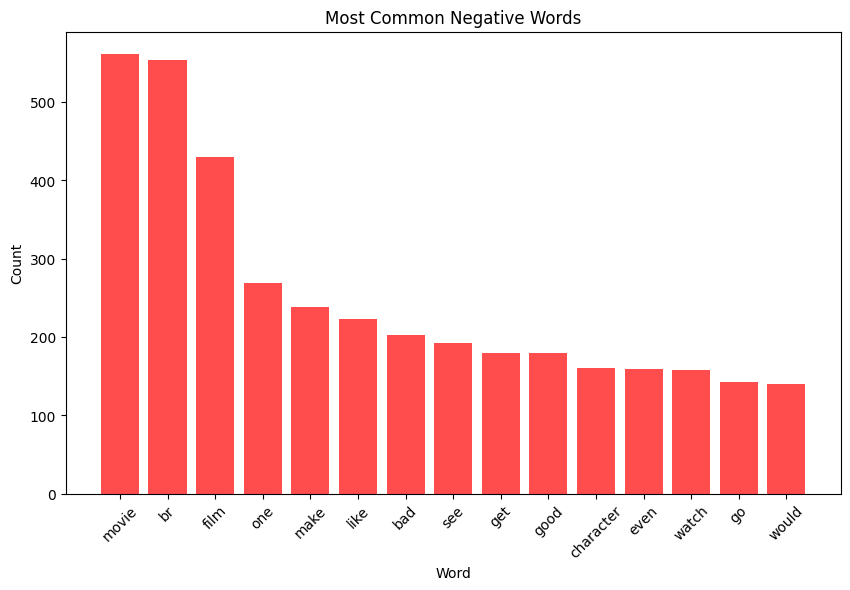

In [11]:
# Plot most common words for each sentiment
plt.figure(figsize=(10, 6))
plt.bar(positive_df['Word'], positive_df['Count'], color='green', alpha=0.7)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Most Common Positive Words')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(negative_df['Word'], negative_df['Count'], color='red', alpha=0.7)
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Most Common Negative Words')
plt.show()

### 5 - Remove Custom Stopwords

Words appearing in both the top positive and top negative lists are unlikely to carry sentiment signal. Remove them as custom stopwords.

In [12]:
# Identify and remove words common to both sentiment classes
custom_stop_words = set(positive_df['Word']).intersection(set(negative_df['Word']))
print(f"Custom stopwords: {custom_stop_words}")

df['clean_review'] = df['clean_review'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stop_words]
)

# Join tokens back into strings for vectorization
df['clean_review'] = df['clean_review'].apply(lambda x: ' '.join(x))
df.head()

Custom stopwords: {'one', 'movie', 'character', 'make', 'like', 'br', 'get', 'see', 'good', 'film', 'go'}


,review,sentiment,review_length,clean_review
0,There is no relation at all between Fortier an...,1,125,relation fortier profiler fact police series v...
1,This movie is a great. The plot is very true t...,1,131,great plot true book classic write mark twain ...
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,177,george cosmatos rambo first blood part ii pure...
3,In the process of trying to establish the audi...,1,119,process try establish audience empathy jake ro...
4,"Yeh, I know -- you're quivering with excitemen...",0,636,yeh know youre quiver excitement well secret l...


### 6 - Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 400
Test set: 100
